In [53]:
!pip install swig


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
!pip install "gymnasium[box2d]"


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import gymnasium as gym
import math


In [3]:
# Класс нейрона скрытого слоя 
class Neuron:
    def __init__(self, input_size):
        self.weights = np.random.randn(input_size) * math.sqrt(1. / input_size)
        self.bias = 0.0

    def activate(self, x):
        z = np.dot(x, self.weights) + self.bias
        return np.tanh(z)
n = Neuron(input_size=8)
print(n.weights)
x = np.random.randn(8)
output = n.activate(x)
print("Neuron output:", output)

[-0.55778856 -0.4119762   0.56217338 -0.49970821  0.54927307  0.28364168
 -0.46093195  0.25638337]
Neuron output: -0.5240417772753702


In [4]:
# Популяция нейронов скрытого слоя 
class NeuronPopulation:
    def __init__(self, input_size, population_size):
        self.neurons = [Neuron(input_size) for _ in range(population_size)]

    def mutate(self, neuron, mutation_strength):
        new_neuron = Neuron(len(neuron.weights))
        new_neuron.weights = neuron.weights + np.random.normal(0, mutation_strength, size=neuron.weights.shape)
        new_neuron.bias = neuron.bias + np.random.normal(0, mutation_strength)
        return new_neuron

    def evolve(self, fitnesses, mutation_strength):
        sorted_indices = np.argsort(fitnesses)[::-1]
        top = [self.neurons[i] for i in sorted_indices[:len(self.neurons)//2]]
        new_population = []
        for neuron in top:
            new_population.append(neuron)
            new_population.append(self.mutate(neuron, mutation_strength))
        self.neurons = new_population[:len(self.neurons)]

pop = NeuronPopulation(input_size=8, population_size=5)
print("Веса первого нейрона:", pop.neurons[0].weights)

mut_neuron = pop.mutate(pop.neurons[0], mutation_strength=0.1)
print("Мутировавшие веса:", mut_neuron.weights)

fitnesses = np.random.randn(5)
pop.evolve(fitnesses, mutation_strength=0.1)
print("Популяция эволюционировала - новые веса первого нейрона:", pop.neurons[0].weights)


Веса первого нейрона: [ 0.0602053  -0.11697502  0.35947148 -0.19071556  0.04230259 -0.04607025
  0.38792614  0.33833324]
Мутировавшие веса: [ 0.14639865 -0.07092814  0.27370653 -0.24190621  0.17969783 -0.05652651
  0.24906428  0.38592618]
Популяция эволюционировала - новые веса первого нейрона: [-0.42608187  0.24870947  0.01912226 -0.37836531  0.17262993 -0.22524914
  0.40093823 -0.25965439]


In [5]:
class OutputLayer:
    def __init__(self, hidden_size, output_size):
        self.weights = np.random.randn(hidden_size, output_size) * np.sqrt(1.0 / hidden_size)

    def forward(self, hidden_output):
        return np.dot(hidden_output, self.weights)
    
ol = OutputLayer(hidden_size=4, output_size=3)
hidden_output = np.array([0.5, -0.2, 0.1, 0.9])
output = ol.forward(hidden_output)
print("Выход:", output)
print("Веса:", ol.weights)


Выход: [ 0.20866985  0.42842837 -0.43016024]
Веса: [[-0.16753248 -0.50053019 -0.20182295]
 [-0.35611514 -0.22715583 -0.22665866]
 [-0.58046501  0.09250306  0.37248953]
 [ 0.31028841  0.69334666 -0.45758827]]


In [19]:
class OutputPopulation:
    def __init__(self, hidden_size, output_size, population_size):
        self.layers = [OutputLayer(hidden_size, output_size) for _ in range(population_size)]

    def mutate(self, layer, mutation_strength):
        new_layer = OutputLayer(layer.weights.shape[0], layer.weights.shape[1])
        new_layer.weights = layer.weights + np.random.normal(0, mutation_strength, size=layer.weights.shape)
        return new_layer

    def evolve(self, fitnesses, mutation_strength):
        sorted_indices = np.argsort(fitnesses)[::-1]
        top = [self.layers[i] for i in sorted_indices[:len(self.layers)//2]]
        new_population = []
        for layer in top:
            new_population.append(layer)
            new_population.append(self.mutate(layer, mutation_strength))
        self.layers = new_population[:len(self.layers)]

In [7]:
# Полная сеть из скрытых нейронов и выходного слоя 
class Network:
    def __init__(self, neurons, output_layer):
        self.neurons = neurons
        self.output_layer = output_layer

    def forward(self, x):
        hidden_outputs = np.array([neuron.activate(x) for neuron in self.neurons])
        logits = self.output_layer.forward(hidden_outputs)
        return np.argmax(logits)
# Тест Network
neurons = [Neuron(input_size=8) for _ in range(4)]
output_layer = OutputLayer(hidden_size=4, output_size=4)
net = Network(neurons, output_layer)

x = np.random.randn(8)
action = net.forward(x)
print("Выбранное действие:", action)

Выбранное действие: 2


In [8]:
def save_network(neurons, output_layer, filename="hesp_best.npz"):
    neuron_weights = [np.concatenate([n.weights, [n.bias]]) for n in neurons]
    output_weights = output_layer.weights
    np.savez(filename, neuron_weights=neuron_weights, output_weights=output_weights)

def load_network(filename):
    data = np.load(filename, allow_pickle=True)
    neuron_weights = data["neuron_weights"]
    output_weights = data["output_weights"]
    neurons = []
    for nw in neuron_weights:
        w, b = nw[:-1], nw[-1]
        neuron = Neuron(len(w))
        neuron.weights = w
        neuron.bias = b
        neurons.append(neuron)
    output_layer = OutputLayer(output_weights.shape[0], output_weights.shape[1])
    output_layer.weights = output_weights
    return Network(neurons, output_layer)

SAVE_PATH='E:\\Магистратура\\2 семестр\\Н-эволюционные вычисления\\видео\\С ПК\\'

In [ ]:
import copy
# NetworkPopulation 
class NetworkPopulation:
    def __init__(self, neuron_populations, output_population, population_size):
        self.population_size = population_size
        self.networks = []

        # инициализация случайных сетей
        for _ in range(population_size):
            hidden_neurons = [np.random.choice(pop.neurons) for pop in neuron_populations]
            output_layer = np.random.choice(output_population.layers)
            self.networks.append( (hidden_neurons, output_layer) )

    def mutate_network(self, neurons, output_layer, neuron_mutation_strength, output_mutation_strength):
        # Мутируем каждый нейрон
        new_neurons = [Neuron(len(neuron.weights)) for neuron in neurons]
        for i, neuron in enumerate(neurons):
            new_neurons[i].weights = neuron.weights + np.random.normal(0, neuron_mutation_strength, size=neuron.weights.shape)
            new_neurons[i].bias = neuron.bias + np.random.normal(0, neuron_mutation_strength)

        # Мутируем output layer
        new_output_layer = OutputLayer(output_layer.weights.shape[0], output_layer.weights.shape[1])
        new_output_layer.weights = output_layer.weights + np.random.normal(0, output_mutation_strength, size=output_layer.weights.shape)

        return (new_neurons, new_output_layer)

    def evolve(self, fitnesses, neuron_mutation_strength, output_mutation_strength):
        sorted_indices = np.argsort(fitnesses)[::-1]
        top_indices = sorted_indices[:len(sorted_indices)//2]

        new_population = []

        # Каждая сеть скрещивается с более приспособленной
        for idx in top_indices:
            parent1 = self.networks[idx]

            # выбираем второго родителя из лучших
            mate_idx = np.random.choice(top_indices)
            parent2 = self.networks[mate_idx]

            # u-point crossover (по нейронам)
            new_neurons = []
            for n1, n2 in zip(parent1[0], parent2[0]):
                if np.random.rand() < 0.5:
                    new_neurons.append(copy.deepcopy(n1))
                else:
                    new_neurons.append(copy.deepcopy(n2))

            # output layer crossover (простое копирование одного из родителей)
            if np.random.rand() < 0.5:
                new_output_layer = copy.deepcopy(parent1[1])
            else:
                new_output_layer = copy.deepcopy(parent2[1])

            # мутация новой сети
            child = self.mutate_network(new_neurons, new_output_layer, neuron_mutation_strength, output_mutation_strength)

            # сохраняем обе: родителя (родителя оставляем) + ребенка
            new_population.append(parent1)
            new_population.append(child)

        self.networks = new_population[:self.population_size]


# Теперь новый HESPTrainer 
class HESPTrainer:
    def __init__(self, input_size, hidden_size, output_size, population_size=10, mutation_strength=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.population_size = population_size
        self.mutation_strength = mutation_strength

        self.neuron_populations = [NeuronPopulation(input_size, population_size) for _ in range(hidden_size)]
        self.output_population = OutputPopulation(hidden_size, output_size, population_size)

        # добавляем L2 — популяцию сетей
        self.network_population = NetworkPopulation(self.neuron_populations, self.output_population, population_size)

    def evaluate(self, env, network, episodes=2):
        total_reward = 0
        for _ in range(episodes):
            state, _ = env.reset()
            done = False
            while not done:
                action = network.forward(state)
                state, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                done = terminated or truncated
        return total_reward / episodes

    def evolve(self, env, generations):
        scores = []  
        for gen in range(generations):
            # ---- Эволюция нейронов ----
            fitness_sums = [np.zeros(self.population_size) for _ in range(self.hidden_size)]
            counts = [np.zeros(self.population_size) for _ in range(self.hidden_size)]
            output_fitness_sum = np.zeros(self.population_size)
            output_fitness_count = np.zeros(self.population_size)

            # 1. Формируем сети из нейронов L1
            for _ in range(self.population_size):
                hidden_indices = [np.random.randint(0, self.population_size) for _ in range(self.hidden_size)]
                hidden_neurons = [self.neuron_populations[i].neurons[idx] for i, idx in enumerate(hidden_indices)]

                output_index = np.random.randint(0, self.population_size)
                output_layer = self.output_population.layers[output_index]

                net = Network(hidden_neurons, output_layer)
                fitness = self.evaluate(env, net)

                # если сеть лучше худшей в L2 — вставляем в L2
                l2_fitnesses = [self.evaluate(env, Network(net_hidden, net_output)) for net_hidden, net_output in self.network_population.networks]
                worst_idx = np.argmin(l2_fitnesses)

                if fitness > l2_fitnesses[worst_idx]:
                    self.network_population.networks[worst_idx] = (hidden_neurons, output_layer)

                # аккумулируем фитнес по нейронам
                for i, idx in enumerate(hidden_indices):
                    fitness_sums[i][idx] += fitness
                    counts[i][idx] += 1

                # по выходному слою
                output_fitness_sum[output_index] += fitness
                output_fitness_count[output_index] += 1

            # 2. Оценка сетей L2
            l2_fitnesses = [self.evaluate(env, Network(net_hidden, net_output)) for net_hidden, net_output in self.network_population.networks]
            best_l2_idx = np.argmax(l2_fitnesses)
            best_l2_fitness = l2_fitnesses[best_l2_idx]

            # если сеть L2 лучше лучшей из L1 — её нейроны копируются в L1
            avg_fitnesses = [np.divide(f, c, out=np.zeros_like(f), where=c != 0) for f, c in zip(fitness_sums, counts)]
            output_avg_fitness = np.divide(output_fitness_sum, output_fitness_count, out=np.zeros_like(output_fitness_sum), where=output_fitness_count != 0)

            best_l1_score = max(max(f) for f in avg_fitnesses + [output_avg_fitness])

            if best_l2_fitness > best_l1_score:
                print("L2 -> L1: пересадка нейронов")
                l2_neurons, l2_output_layer = self.network_population.networks[best_l2_idx]

                # заменяем лучшие нейроны в популяциях
                for i in range(self.hidden_size):
                    self.neuron_populations[i].neurons[0] = copy.deepcopy(l2_neurons[i])

                # и лучший output layer
                self.output_population.layers[0] = copy.deepcopy(l2_output_layer)

            # 3. Эволюция L1
            for i in range(self.hidden_size):
                self.neuron_populations[i].evolve(avg_fitnesses[i], self.mutation_strength)
            self.output_population.evolve(output_avg_fitness, self.mutation_strength)

            # 4. Эволюция L2
            self.network_population.evolve(l2_fitnesses, self.mutation_strength, self.mutation_strength)

            print(f"Поколение {gen+1}: лучший фитнес L2 = {best_l2_fitness:.2f}")
            if gen in [0, generations // 2, generations - 1]:
                best_idx = np.argmax(l2_fitnesses)
                best_net = self.network_population.networks[best_idx]
                visualize_network(Network(best_net[0], best_net[1]), input_size=self.input_size, output_size=self.output_size, epoch=gen+1)
            scores.append(best_l2_fitness)

        # Возвращаем лучшую сеть L2
        best_idx = np.argmax(l2_fitnesses)
        best_net = self.network_population.networks[best_idx]
        self.save_network(best_net[0], best_net[1], filename=f"hesp_best_gen{generations}.npz")
        return Network(best_net[0], best_net[1]), scores

    def save_network(self, neurons, output_layer, filename="hesp_best.npz"):
        neuron_weights = [np.concatenate([n.weights, [n.bias]]) for n in neurons]
        output_weights = output_layer.weights
        np.savez(filename, neuron_weights=neuron_weights, output_weights=output_weights)

In [ ]:
!pip install networkx

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 2.8 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.0 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 4.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import networkx as nx
import matplotlib.pyplot as plt
def visualize_network(network, input_size=8, output_size=4, epoch=0):
    G = nx.DiGraph()
    for i in range(input_size):
        G.add_node(f"I{i}", pos=(0, -i*2.3))
    for h in range(len(network.neurons)):
        G.add_node(f"H{h}", pos=(1, -h))
    for o in range(output_size):
        G.add_node(f"O{o}", pos=(2, -o*2.3))
    for h, neuron in enumerate(network.neurons):
        for i, w in enumerate(neuron.weights):
            G.add_edge(f"I{i}", f"H{h}", weight=w)
    for o in range(output_size):
        for h in range(len(network.neurons)):
            w = network.output_layer.weights[h][o]
            G.add_edge(f"H{h}", f"O{o}", weight=w)
    pos = nx.get_node_attributes(G, 'pos')
    weights = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(9, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in weights.items()}, font_size=7)
    plt.title(f"Network Structure — Epoch {epoch}")
    plt.axis('off')
    plt.show()

In [11]:
import matplotlib.pyplot as plt
def plot_scores(scores):
    x = range(0,len(scores))
    y = scores
    plt.plot(x, y)
    plt.xlabel("Поколение")
    plt.ylabel("Лучший fitness L2")
    plt.title("Динамика обучения H-ESP")
    plt.grid()
    plt.show()

In [12]:
import imageio
def show_video_of_network(network, env_name="LunarLander-v3", video_name="hesp_demo", max_steps=1000):
    env = gym.make(env_name, render_mode='rgb_array', max_episode_steps=max_steps)
    state, _ = env.reset()
    done = False
    frames = []

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = network.forward(state)
        state, _, done, _, _ = env.step(action)
        if done:
            break
    

    env.close()
    imageio.mimsave(f"{SAVE_PATH + video_name}.mp4", frames, fps=30)


Поколение 1: лучший фитнес L2 = -104.15


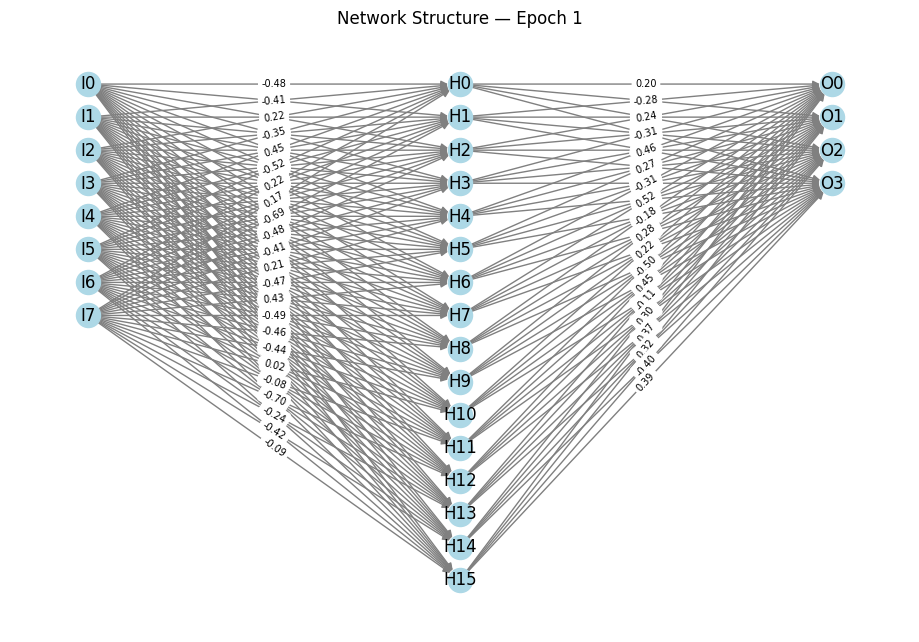

Поколение 2: лучший фитнес L2 = -25.65
Поколение 3: лучший фитнес L2 = -77.15
Поколение 4: лучший фитнес L2 = -77.86
Поколение 5: лучший фитнес L2 = -36.67
Поколение 6: лучший фитнес L2 = -11.47
L2 -> L1: пересадка нейронов
Поколение 7: лучший фитнес L2 = 90.32
Поколение 8: лучший фитнес L2 = -65.45
Поколение 9: лучший фитнес L2 = -74.06
Поколение 10: лучший фитнес L2 = -42.37
Поколение 11: лучший фитнес L2 = -50.38
Поколение 12: лучший фитнес L2 = -32.24
Поколение 13: лучший фитнес L2 = -30.78
L2 -> L1: пересадка нейронов
Поколение 14: лучший фитнес L2 = 118.94
Поколение 15: лучший фитнес L2 = -54.96
Поколение 16: лучший фитнес L2 = -54.94
Поколение 17: лучший фитнес L2 = -43.85
Поколение 18: лучший фитнес L2 = -42.06
Поколение 19: лучший фитнес L2 = -42.53
Поколение 20: лучший фитнес L2 = -64.40
Поколение 21: лучший фитнес L2 = -45.71
Поколение 22: лучший фитнес L2 = -43.93
Поколение 23: лучший фитнес L2 = -80.74
Поколение 24: лучший фитнес L2 = -14.45
Поколение 25: лучший фитнес L2 

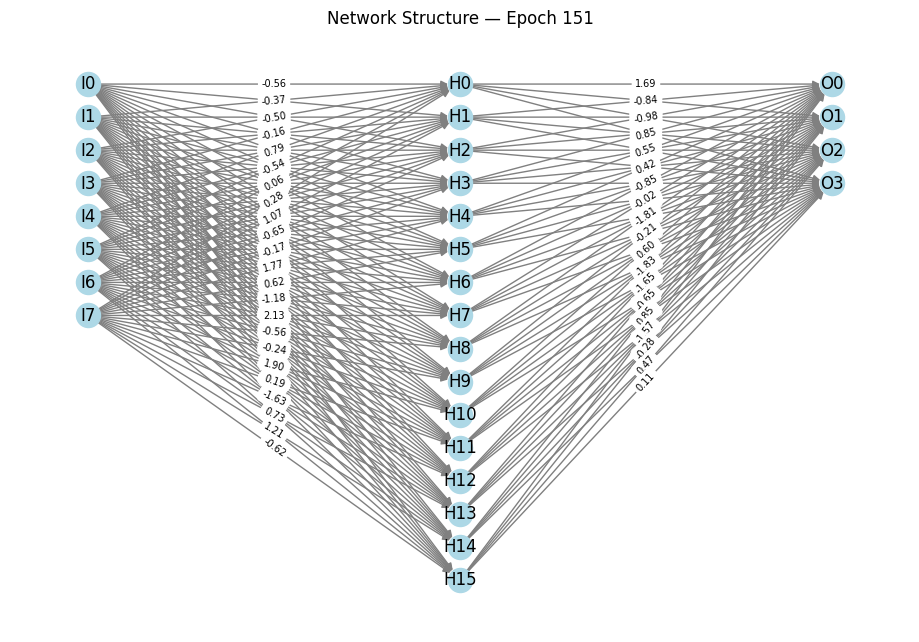

Поколение 152: лучший фитнес L2 = 256.33
Поколение 153: лучший фитнес L2 = 258.05
L2 -> L1: пересадка нейронов
Поколение 154: лучший фитнес L2 = 258.20
L2 -> L1: пересадка нейронов
Поколение 155: лучший фитнес L2 = 264.98
L2 -> L1: пересадка нейронов
Поколение 156: лучший фитнес L2 = 272.58
L2 -> L1: пересадка нейронов
Поколение 157: лучший фитнес L2 = 261.71
L2 -> L1: пересадка нейронов
Поколение 158: лучший фитнес L2 = 259.18
L2 -> L1: пересадка нейронов
Поколение 159: лучший фитнес L2 = 256.63
L2 -> L1: пересадка нейронов
Поколение 160: лучший фитнес L2 = 263.84
Поколение 161: лучший фитнес L2 = 267.64
L2 -> L1: пересадка нейронов
Поколение 162: лучший фитнес L2 = 286.64
L2 -> L1: пересадка нейронов
Поколение 163: лучший фитнес L2 = 273.29
L2 -> L1: пересадка нейронов
Поколение 164: лучший фитнес L2 = 270.80
L2 -> L1: пересадка нейронов
Поколение 165: лучший фитнес L2 = 261.41
L2 -> L1: пересадка нейронов
Поколение 166: лучший фитнес L2 = 283.38
L2 -> L1: пересадка нейронов
Поколени

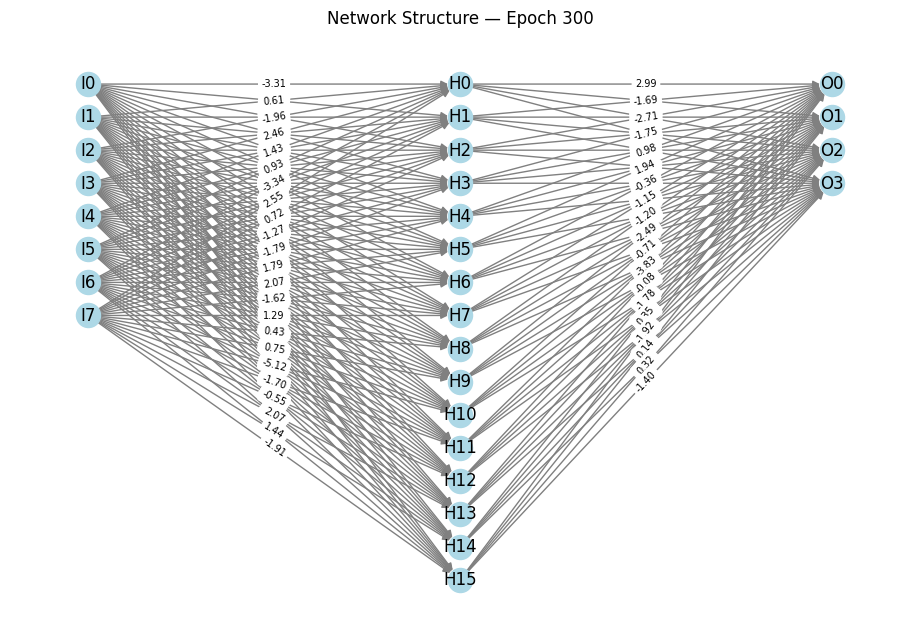

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Видео готово


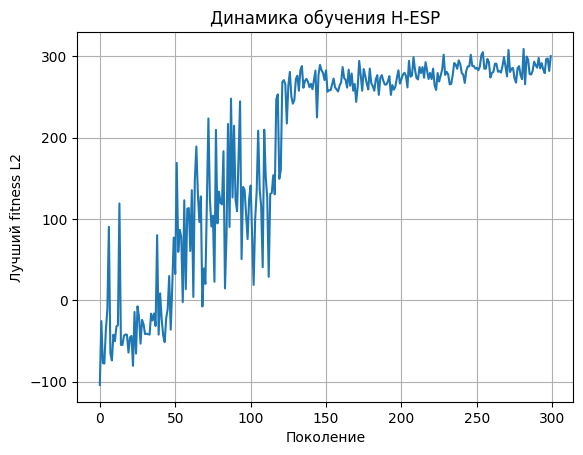

In [ ]:
def train_hesp_on_lunarlander(hidden_size, generations=1000, mutation_strength=0.1):
    env = gym.make("LunarLander-v3")
    # population_size - должно быть
    trainer = HESPTrainer(input_size=8, hidden_size=hidden_size, output_size=4, population_size=20, mutation_strength=mutation_strength)
    net, scores = trainer.evolve(env, generations)  # пока 2 поколения для теста
    env.close()
    return net, scores


net, scores = train_hesp_on_lunarlander(16, 300, mutation_strength=0.2)


net_ = load_network("hesp_best_gen300.npz")
show_video_of_network(net_)
print('Видео готово')
plot_scores(scores)

In [25]:
print(scores)

[-86.69479233898981, 123.58018596661904, -89.88358808985251, 83.43049707372234, -28.004290254154967, -4.273178598191137, -42.11033346120062, -74.71120864741862, -32.90933459237324, -86.02170094586398, -46.726363365929885, -51.280667221709514, -89.79620729699455, -63.38163555583607, -56.425528223339164, -63.339827568968325, -84.4802808467264, -52.75482999436244, -66.05073812525144, -78.45746798253862, -30.003596177567275, -40.63735116144878, -48.09345221885847, -40.13199486957247, -59.147986623779346, -34.63007697575261, -46.346063586598774, -40.66662946830674, -8.376883496815644, -6.376879977801565, -39.50833579513087, -30.71275258046786, -46.19885149070089, -37.6894906088736, -28.098106485960198, -58.37832609392233, -9.850694039755417, -7.102018752993466, -45.79104048101544, -55.264485763275, -28.193417775187662, -61.9004080511189, -57.366108293030855, -69.50286560127725, -96.35238317731576, -17.050485704225316, -56.17103185492295, -101.37193789422066, -95.80444260491687, -88.54195668

In [27]:
net_ = load_network("hesp_best_gen300.npz")
# show_video_of_network(net, video_name="last_demo")
show_video_of_network(net_, video_name="best_demo")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Поколение 1: лучший фитнес L2 = -27.48


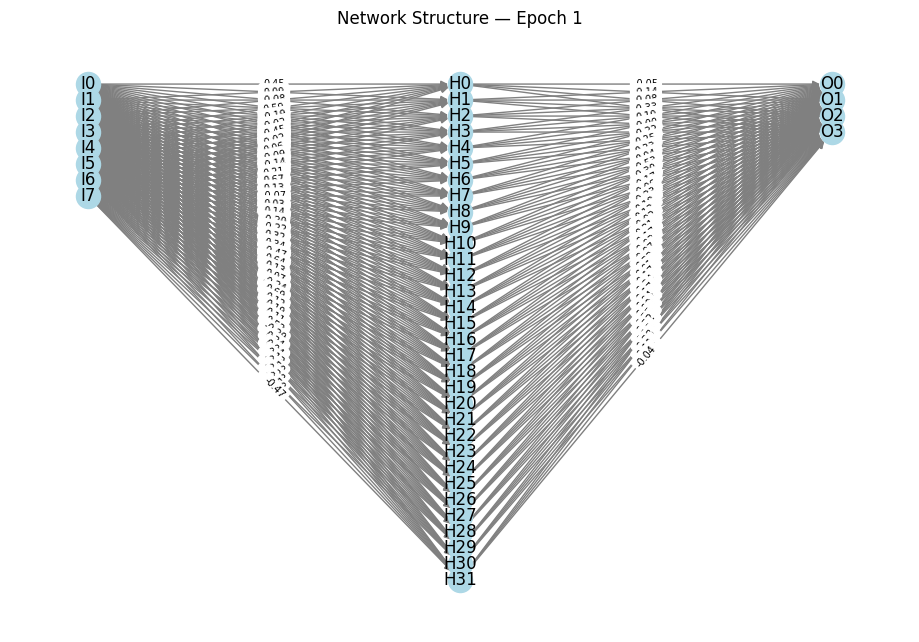

Поколение 2: лучший фитнес L2 = -92.87
Поколение 3: лучший фитнес L2 = -36.46
Поколение 4: лучший фитнес L2 = -31.97
Поколение 5: лучший фитнес L2 = -46.78
Поколение 6: лучший фитнес L2 = -78.34
Поколение 7: лучший фитнес L2 = -61.54
Поколение 8: лучший фитнес L2 = -38.63
Поколение 9: лучший фитнес L2 = -40.14
Поколение 10: лучший фитнес L2 = -58.25
Поколение 11: лучший фитнес L2 = -58.00
Поколение 12: лучший фитнес L2 = -27.71
Поколение 13: лучший фитнес L2 = -52.79
Поколение 14: лучший фитнес L2 = -32.49
Поколение 15: лучший фитнес L2 = -33.89
Поколение 16: лучший фитнес L2 = -84.84
Поколение 17: лучший фитнес L2 = -92.09
Поколение 18: лучший фитнес L2 = -55.19
Поколение 19: лучший фитнес L2 = -81.83


KeyboardInterrupt: 

In [28]:
net, scores = train_hesp_on_lunarlander(32, 300, mutation_strength=0.1)

net_ = load_network("hesp_best_gen300.npz")
show_video_of_network(net, video_name="last_demo")
show_video_of_network(net_, video_name="best_demo")

print('Видео готово')
plot_scores(scores)

In [73]:
!pip install imageio


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
!pip install imageio[ffmpeg]

   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
    --------------------------------------- 0.5/31.2 MB 2.8 MB/s eta 0:00:12
   -- ------------------------------------- 1.8/31.2 MB 4.6 MB/s eta 0:00:07
   --- ------------------------------------ 2.4/31.2 MB 3.7 MB/s eta 0:00:08
   ---- ----------------------------------- 3.1/31.2 MB 3.8 MB/s eta 0:00:08
   ----- ---------------------------------- 4.2/31.2 MB 4.1 MB/s eta 0:00:07
   ------ --------------------------------- 5.2/31.2 MB 4.6 MB/s eta 0:00:06
   ---------- ----------------------------- 8.4/31.2 MB 5.8 MB/s eta 0:00:04
   ------------- -------------------------- 10.5/31.2 MB 6.4 MB/s eta 0:00:04
   --------------- ------------------------ 12.3/31.2 MB 6.8 MB/s eta 0:00:03
   ------------------ --------------------- 14.4/31.2 MB 7.1 MB/s eta 0:00:03
   -------------------- ------------------- 15.7/31.2 MB 7.1 MB/s eta 0:00:03
   ------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


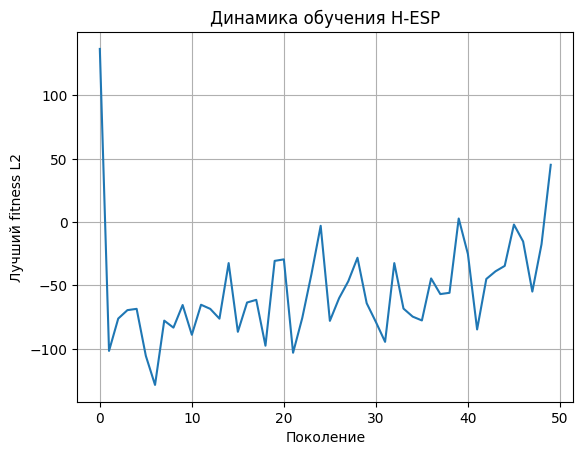

Поколение 1: лучший фитнес L2 = -73.83


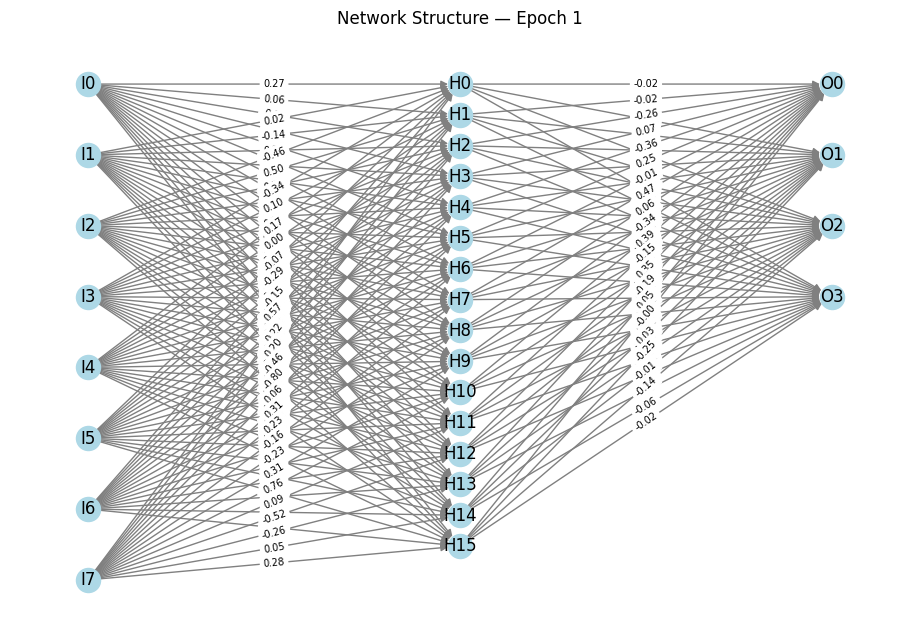

Поколение 2: лучший фитнес L2 = -84.02


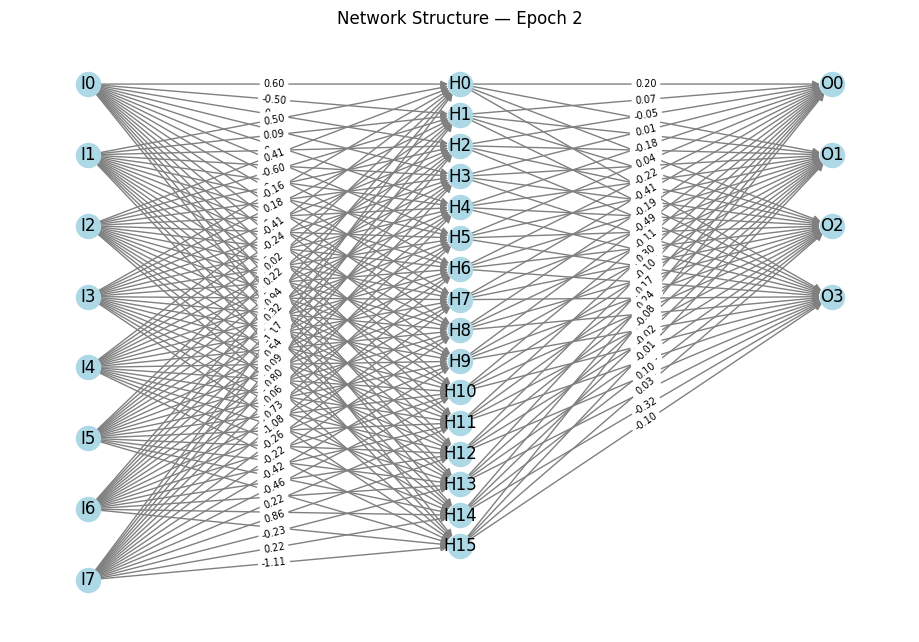

In [34]:
net, scores = train_hesp_on_lunarlander(16, 2, mutation_strength=0.2)